# Fake news detection
The purpose of this project is to build a machine learning model that can classify news articles as real or fake based on their content. A model capable of recognizing fake news could be used as a browser extension to inform the user whether the news articles they are viewing seem credible or not. It could be implemented as part of social media services, or made a separate service where the user could paste a link and be informed whether the news article is fake or not. Implementations like this could help hinder the spread of misinformation.


There are seven parts to the project.
1. [Introduction](#1.-Introduction)
2. [Data preprocessing](#2.-Data-preprocessing)
3. [Exploratory data analysis](#3.-Exploratory-data-analysis)
4. [Feature engineering](#4.-Feature-engineering)
5. [Model building](#5.-Model-building)
6. [Model evaluation](#6.-Model-evaluation)
7. [Model interpretation](#7.-Model-interpretation)


## 1. Introduction

The data for the project is from Kaggle. [The fake news detection dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets) contains 21 417 rows of real news and 23 481 fake news at the time when the data was downloaded for the project. The real news articles have been collected from Reuters, which is one of the largest news agencies in the world. The fake news articles were collected from multiple sources, which had been flagged by Politifact, a fact-checking organization in the United States. The majority of the news articles are on the topics of politics and world news, and collected from the years 2016 and 2017.

GPT-4o was used to debug and generate code for sections 2-7 of this notebook. 

The python libraries and modules used for this project:
* Pandas is used for reading and manipulating data. Pandas dataframe provides a structure for handling and cleaning data.
* Pandas uses numpy internally, and it can be used explicitly for numerical array operations.
* re is the regular expressions library part of the Python standard library. It is very handy for matching and modifying string data.
* Seaborn and matplotlib are both visualization libraries, which are used for exploratory data analysis as well as model evaluation and interpretation.
* scikit-learn and xgboost provide the machine learning models which are used in the project.
* nltk is a library of text processing tools for natural language processing.
* wordcloud is used to visualize the most frequent words in the dataset.
* shap is used for understanding which features influence the predictions made by machine learning models.
* kagglehub is used to import the data directly from Kaggle


In [1]:
!pip install pandas; numpy; seaborn; matplotlib; scikit-learn; xgboost; nltk; wordcloud; shap; kagglehub

In [2]:
import pandas as pd
import numpy as np
import kagglehub
from pathlib import Path
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score
import shap

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anni_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anni_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Data preprocessing
In this section we read the data and combine it into one dataframe. 

The text and title of the are run through a natural language processing process, in which the text is turned to lowercase and all characters other than alphabetical as well as stopwords are removed. Additionally, stemming removes inflections from a word and returns its stem. For instance the words "walks" and "walking" would both be stemmed to "walk". 

The purpose of this process is to make the language easier for algorithms to process. 

The data is shuffled after the true and fake news data is combined into one dataframe. This is important because in the original dataframe all the fake news articles are preceded by all the true news articles. If the data were not shuffled at any stage the model could make prediction based on placement in the dataset.

In addition to the regular preprocessing of the text data, the word Reuters is being removed from the dataset. Because the true news articles are all sourced from Reuters, the presence of this word can make the predictive model use it as a shorcut in its predictions. Additionally, words like "via", "image","video" and weekdays that refer to the metadata of the article are removed.
Ideally, the model would learn deeper semantic patterns instead of using words like these as surface-level cues.

In [3]:
import os

# Download the files via kagglehub
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

fake_path = os.path.join(path, "News _dataset", "Fake.csv")
true_path = os.path.join(path, "News _dataset", "True.csv")

# Read both files
df_fake = pd.read_csv(fake_path)
df_true = pd.read_csv(true_path)

# Add a column to indicate true/fake. 0 indicates fake, 1 indicates true.
df_fake["label"] = 0
df_true["label"] = 1

# combine the two dataset into one. 
df = pd.concat([df_fake, df_true], ignore_index=True)

# Shuffle the combined dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the resulting dataframe
print(df["label"].value_counts())
print("\nRows in the original csv files")
print("Fake rows", len(df_fake), "\nTrue rows", len(df_true))


label
0    23481
1    21417
Name: count, dtype: int64

Rows in the original csv files
Fake rows 23481 
True rows 21417


In [4]:
# Check for any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [5]:
# Take a look at the first 5 rows of the dataframe
df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [6]:
# Processing the text data, starting with turning everything to lowercase
df["title"] = df["title"].str.lower()
df["text"] = df["text"].str.lower()

# Remove punctuation and special characters using regex
df["title"] = df["title"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
df["text"] = df["text"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Remove stopwords
stop_words = set(stopwords.words("english"))
df["title"] = df["title"].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
df["text"] = df["text"].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Stemming
lemmatizer = WordNetLemmatizer()
df["title"] = df["title"].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))
df["text"] = df["text"].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Remove source-words like Reuters and words referring to metadata of the article
source_words = ["reuters", "via", "image", "video", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
df["title"] = df["title"].apply(lambda x: ' '.join(word for word in x.split() if word not in source_words))
df["text"] = df["text"].apply(lambda x: ' '.join(word for word in x.split() if word not in source_words))
                                

# Check the first five rows after processing
df.head()

,title,text,subject,date,label
0,ben stein call th circuit court committed coup...,st century wire say ben stein reputable profes...,US_News,"February 13, 2017",0
1,trump drop steve bannon national security council,washington u president donald trump removed ch...,politicsNews,"April 5, 2017",1
2,puerto rico expects u lift jones act shipping ...,puerto rico governor ricardo rossello said exp...,politicsNews,"September 27, 2017",1
3,oops trump accidentally confirmed leaked israe...,donald trump embarrassed country accidentally ...,News,"May 22, 2017",0
4,donald trump head scotland reopen golf resort,glasgow scotland u presidential candidate go a...,politicsNews,"June 24, 2016",1


In [7]:
# Drop rows that have duplicate text
df.drop_duplicates(subset="text", inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38510 entries, 0 to 38509
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    38510 non-null  object
 1   text     38510 non-null  object
 2   subject  38510 non-null  object
 3   date     38510 non-null  object
 4   label    38510 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [8]:
# Check the number of fake and true news rows in the dataset after dropping duplicates
print(df["label"].value_counts())


label
1    21063
0    17447
Name: count, dtype: int64


Originally the dataset had 21417 rows of true news(1) and 23481 rows of fake news(0). After dropping duplicates, there is significantly less fake news articles than before. One possible reason for this may be that many sources post the same fake articles and this behaviour is not as prevalent with true news.

## 3. Exploratory data analysis
In this section we explore the data more to gain a better understanding of it. 

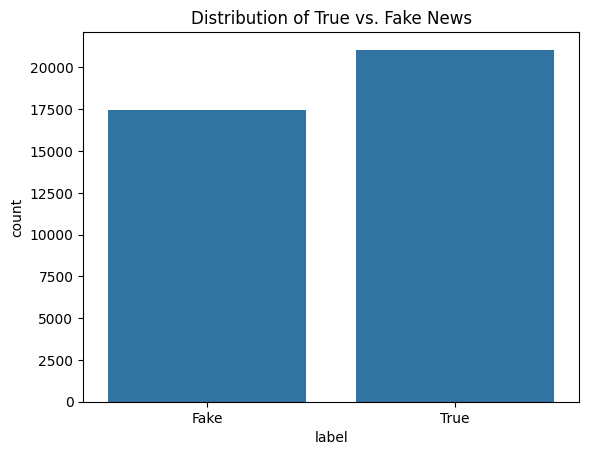

In [9]:
# Visualize the distribution of true vs. fake news in the dataset
sns.countplot(x="label", data=df)
plt.title("Distribution of True vs. Fake News")
plt.xticks([0, 1], ["Fake", "True"])
plt.show()

In [10]:
# Calculate text length
df["text_length"] = df["text"].apply(lambda x: len(x.split()))

# Drop all rows where text length is 0
print("Before:", len(df))
df = df[df["text_length"] > 0]
print("After:", len(df))

Before: 38510
After: 38509


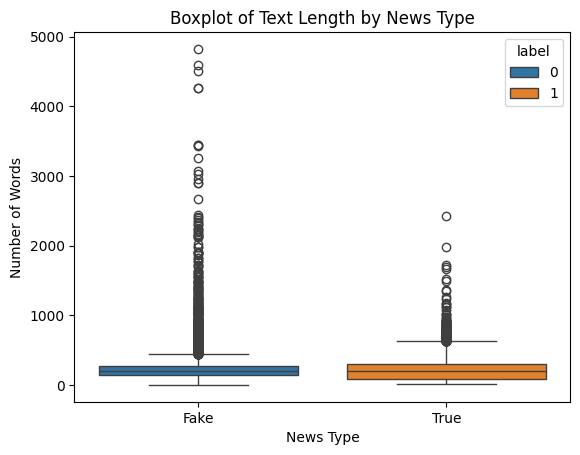

In [11]:
# Visualize difference in length between true and fake news articles
sns.boxplot(x="label", y="text_length", data=df, hue="label")
plt.xticks([0, 1], ["Fake", "True"])
plt.title("Boxplot of Text Length by News Type")
plt.xlabel("News Type")
plt.ylabel("Number of Words")
plt.show()

In [12]:
# Create descriptive statistics for text length by news type
df.groupby("label")["text_length"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,17446.0,227.886622,198.134997,1.0,148.0,199.0,267.0,4823.0
1,21063.0,223.315245,158.076110,13.0,86.0,207.0,302.0,2426.0


From the boxplot and the descriptive statistics we can see that there is not a very big difference in the distributions of text length between true and fake news. The fake news set has some outliers of very long articles, but mean and median are quite similar between the two categories.

In [13]:
# Discover most common words in fake vs. true articles
def get_top_n_words(corpus, n=None):
    all_words = ' '.join(corpus).split()
    return Counter(all_words).most_common(n)

top_fake_words = get_top_n_words(df[df["label"] == 0]["text"], 10)
top_true_words = get_top_n_words(df[df["label"] == 1]["text"], 10)

print(f"{'Top Fake Words':<25} {'Top True Words'}")
print("-" * 45)

for i in range(10):
    fake_word, fake_count = top_fake_words[i]
    true_word, true_count = top_true_words[i]
    print(f"{fake_word:<15} ({fake_count:>5})     {true_word:<15} ({true_count:>5})")


Top Fake Words            Top True Words
---------------------------------------------
trump           (64069)     said            (97426)
said            (22894)     trump           (53446)
people          (20748)     u               (40375)
president       (19629)     state           (35754)
one             (18259)     would           (31025)
would           (18156)     president       (26516)
state           (15922)     republican      (21926)
donald          (14891)     government      (19140)
u               (14846)     year            (18989)
like            (14456)     house           (16695)


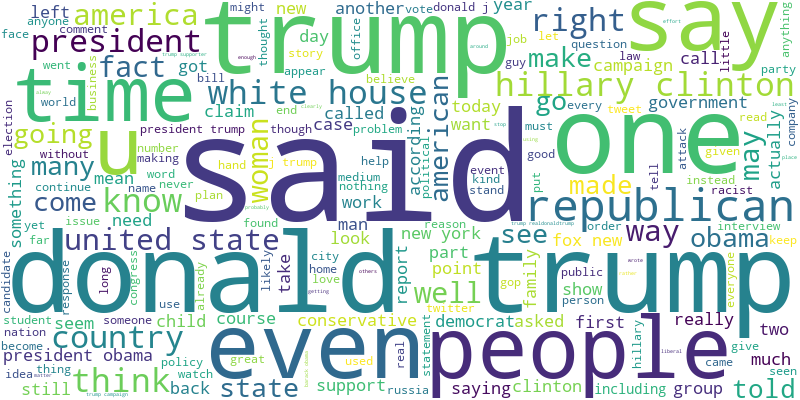

In [14]:
# Create a word cloud visualization of the words in either category

fake_text = ' '.join(df[df["label"] == 0]["text"])
true_text = ' '.join(df[df["label"] == 1]["text"])

# Fake news word cloud
WordCloud(width=800, height=400, background_color="white").generate(fake_text).to_image()


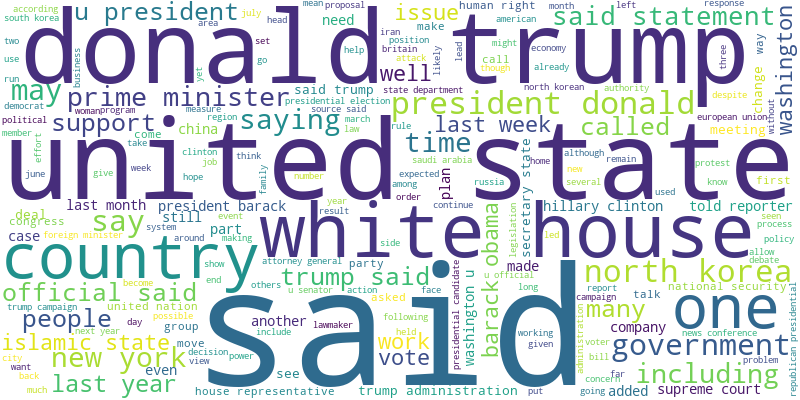

In [15]:
# True news word cloud
WordCloud(width=800, height=400, background_color="white").generate(true_text).to_image()

No easily visible differences between the categories in the top 10 words or the word clouds stand out. As stated in the description of the data set on Kaggle, politics and world news topics are prevalent in the data set. This makes sense, since political influence is one of the goals of fake news.

In [16]:
# Investigate the values of the subject column by category
df.groupby("label")["subject"].value_counts()

label  subject        
0      News                9050
       politics            4335
       left-news           2409
       Government News      869
       Middle-east          400
       US_News              383
1      politicsNews       11139
       worldnews           9924
Name: count, dtype: int64

We can see that though the topics are quite similar, different subject labels have been used for fake news and for true news. This creates the problem that the predictive model could use the subject as a shortcut to making the prediction. Therefore, the subject column will not be included in the training data. Another option could be to discard these subject labels and create new ones using a topic modeling technique like BERTopic.

In [17]:
# Drop subject column
df = df.drop("subject", axis=1)
df.head()

,title,text,date,label,text_length
0,ben stein call th circuit court committed coup...,st century wire say ben stein reputable profes...,"February 13, 2017",0,99
1,trump drop steve bannon national security council,washington u president donald trump removed ch...,"April 5, 2017",1,461
2,puerto rico expects u lift jones act shipping ...,puerto rico governor ricardo rossello said exp...,"September 27, 2017",1,169
3,oops trump accidentally confirmed leaked israe...,donald trump embarrassed country accidentally ...,"May 22, 2017",0,103
4,donald trump head scotland reopen golf resort,glasgow scotland u presidential candidate go a...,"June 24, 2016",1,297


## 4. Feature engineering
In this section the data is converted to numerical format to make it ready for model building. 
The title and text of the article are combined into one text before the text is vectorized.

The TF-IDF methd is used for converting the text. For each word, its frequency in each news article is calculated. This is the TF or term frequency. IDF stands for inverse document frequency and its value is the larger the less frequent a word is in all the documents. The final numerical value for each word is calculated by multiplying these two terms.

In [18]:
# Combine title and text of each article
df["combined_text"] = df["title"] + " " + df["text"]

# Create vectorizer and vectors
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df["combined_text"])

In [19]:
# Separate labels as the target variable
y = df["label"]

The data is split into training and testing data using Train_test_split with a 80/20 divide. 
Stratify=y parameter takes care that the distribution of the fake and true news  is the same across training and test sets as in the original dataset. 

In [20]:
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## 5. Model building
In this section, several models are built, to be compared in the next section. 
* Logistic regression is a simple, interpretable linear model.
* Random Forest Classifier uses a combination of many decision trees and is able to handle non-linear relationships.
* XGBoost (Extreme Gradient Boosting) uses sequentially-built shallow decision trees.
* Multinomial Naive Bayes is a probabilistic model based on Bayes' theorem, that assumes that features (words) are independent.

In [21]:
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("XGBoost", XGBClassifier(eval_metric='logloss')),
    ("Multinomial Naive Bayes", MultinomialNB())
]

In [22]:
trained_models = {}

for name, model in models:
    print(f"Training: {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model

Training: Logistic Regression
Training: Random Forest
Training: XGBoost
Training: Multinomial Naive Bayes


## 6. Model evaluation
In this section the predictive powers of the models are compared to one another.

The models will be evaluated using an accuracy score, a classification report and a confusion matrix.
Accuracy score simply calculates the rate at which the predictions made by the model were labeled correctly.
The classification report goes into more detail, showing statistics separated by label. 
Precision shows the accuracy rate for each category. So, a 0.98 precision for true news (1), means that 98 % of the articles labeled true by the model were actually true. 
Recall measures the sensitivity of the model. It shows the percentage of correctly labeled items of all the items in that class. So, a 0.98 recall for true news (1) means that 98 % of all true news items were labeled as true by the model.
Finally, the F1 score combines precision and recall into a single score.

A confusion matrix is another way to examine the performance of a model. The matrix visualizes the results in four categories:

* True negatives: cases where the model correctly predicted the fake news class (upper-left in the matrix)
* False positives: cases where the model incorrectly predicted the real news class, when it should have been fake news (upper-right)
* False negatives: cases where the model incorrectly predicted the fake news class, when it should have been real news (lower-left)
* True positives: cases where the model correctly predicted the real news class (lower-right)



=== Logistic Regression ===
Accuracy: 0.9787
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3489
           1       0.97      0.99      0.98      4213

    accuracy                           0.98      7702
   macro avg       0.98      0.98      0.98      7702
weighted avg       0.98      0.98      0.98      7702



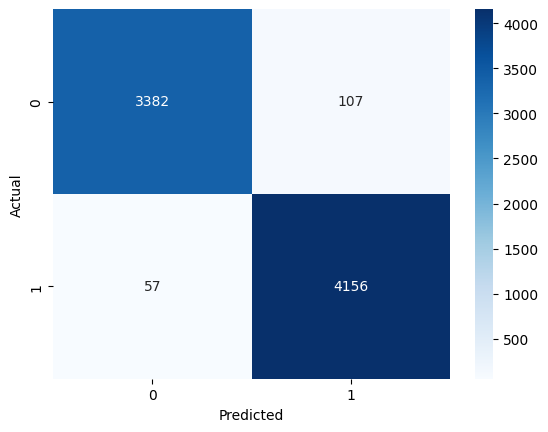


=== Random Forest ===
Accuracy: 0.9701
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      3489
           1       0.97      0.98      0.97      4213

    accuracy                           0.97      7702
   macro avg       0.97      0.97      0.97      7702
weighted avg       0.97      0.97      0.97      7702



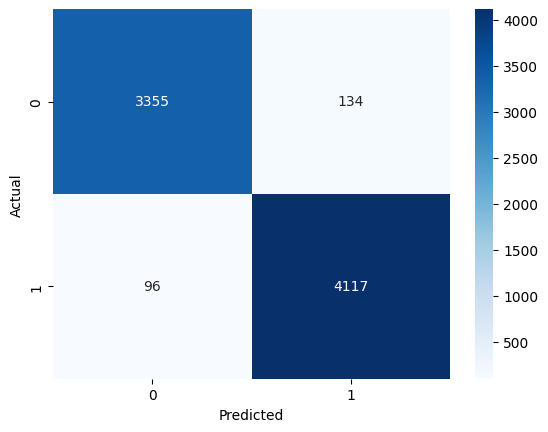


=== XGBoost ===
Accuracy: 0.9799
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3489
           1       0.98      0.99      0.98      4213

    accuracy                           0.98      7702
   macro avg       0.98      0.98      0.98      7702
weighted avg       0.98      0.98      0.98      7702



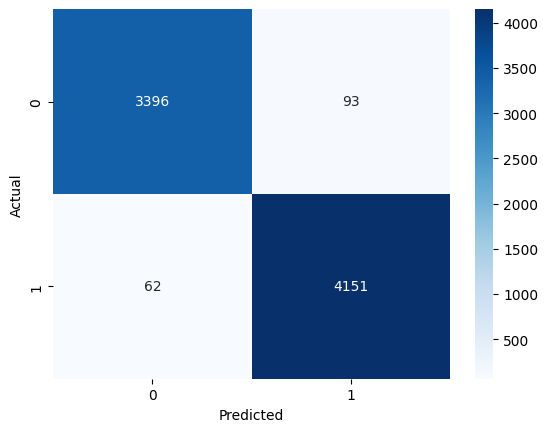


=== Multinomial Naive Bayes ===
Accuracy: 0.9317
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      3489
           1       0.94      0.93      0.94      4213

    accuracy                           0.93      7702
   macro avg       0.93      0.93      0.93      7702
weighted avg       0.93      0.93      0.93      7702



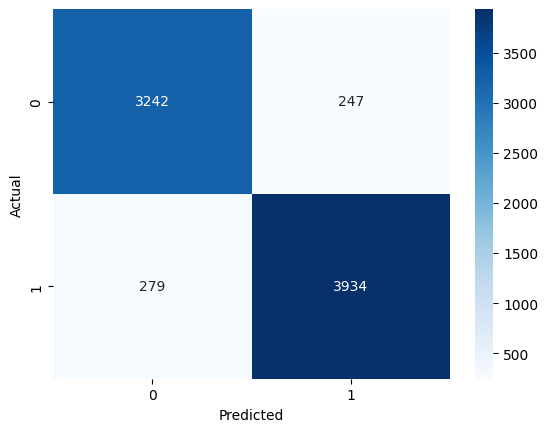

In [23]:
# Evaluate each trained model's accuracy one at a time
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # visualize a confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Let's cross-validate the results of the models to make sure there are no over-fitting problems. Rather than doing a single train/test split like before, in cross-validation the data is split multiple times, so that all parts of the dataset works as testing or training data in turn. 

In [24]:
# Cross-validation with five folds
for name, model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"\n=== {name} ===")
    print("Cross-validation scores:", scores)
    print("Average accuracy:", np.mean(scores))


=== Logistic Regression ===
Cross-validation scores: [0.97727863 0.98130356 0.97818748 0.98169307 0.98259966]
Average accuracy: 0.9802124798665901

=== Random Forest ===
Cross-validation scores: [0.97065697 0.9746819  0.97208517 0.97546092 0.97727568]
Average accuracy: 0.9740321286854968

=== XGBoost ===
Cross-validation scores: [0.9789665  0.9832511  0.98104388 0.98143339 0.98376834]
Average accuracy: 0.9816926452438788

=== Multinomial Naive Bayes ===
Cross-validation scores: [0.93001818 0.93183589 0.93767853 0.93663983 0.94039735]
Average accuracy: 0.9353139547481432


Based on the accuracy scores, classification reports, confusion matrices and the results of the cross-validation XGBoost is the strongest model.



## 7. Model interpretation
In this section the SHAP (Shapley additive explanations) approach is used to take a peek inside the XGBoost model. 

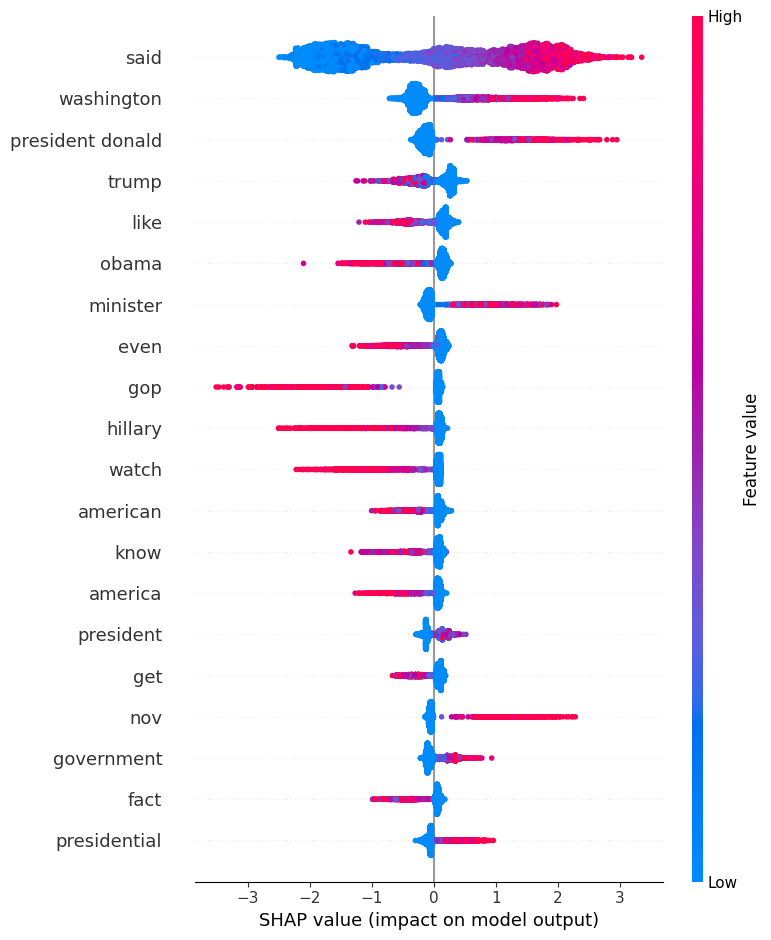

In [25]:
xgboost_model = trained_models["XGBoost"]

explainer = shap.Explainer(xgboost_model)
# Convert the sparse matrix to a dense numpy array
X_dense = X_test.toarray()
shap_values = explainer(X_test) 
shap.summary_plot(shap_values, X_dense, feature_names=tfidf.get_feature_names_out())
plt.show()

The colored dots in the graph are news articles (rows) in the test data. The twenty words and phrases listed on the left are the top features impacting the model's prediction, with the most important one at the top. The SHAP value on the x-axis indicates how much each feature impacted the model's prediction. The further left the dots are, the more they push the prediction towards fake news and vice versa.
The color range from red to blue indicates how many times the word in question was present in each document.

Based on this, the word "said" is the most influential in the model. 
The impact of political words such as "obama", "donald trump" and "hillary" depends on frequency and context.

On the whole, the model performs very well on this data. It's likely the performance wouldn't be as good on news stories outside of politics and world news. More data on more diverse subjects would be required to make the model more able to generalize on a variety of news topics.